# DANA 4830 team project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.image import imread


from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn import metrics

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

import os
import scipy.io

In [2]:
# fig configurations
sns.set(color_codes=True)
plt.rcParams["figure.figsize"] = [10,4]
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rcParams.update({'legend.fontsize': 11})
plt.rcParams.update({'axes.labelsize': 15})
plt.rcParams.update({'font.size': 15})

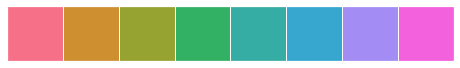

In [3]:
cpalette = sns.color_palette('husl', 8)
sns.palplot(cpalette)

In [4]:
# savefig
def savePNG(f):
    fName = f+".png"
    fPath = os.path.join("figures",fName)
    plt.savefig(fPath, dpi=300)
    
# save df as csv
def saveCSV(f,fName):
    fName2 = fName+".csv"
    fPath = os.path.join("data",fName2)
    f.to_csv(fPath)

## load datasets

## Engineering & Technical Family only
By looking at the [questionaire](https://data.gov.au/data/dataset/cc6c9728-f872-4be0-ac96-ad85b842be9f/resource/851ab942-9158-404c-9640-87c370279a8e/download/2014-aps-employee-census-questionnaire.pdf) we can filter the individuals with Engineering in the APSC in **q16@**

In [26]:
from urllib.request import urlopen
import json

In [27]:
path

'../summer21/DANA4830/Proj'

In [28]:
try:
    df = pd.read_csv(os.path.join(path, "queried-2014.csv"))
except:
    url = "https://data.gov.au/data/api/3/action/datastore_search?resource_id=9b44e035-3bed-40dc-9687-34fc47b9f228&limit=99392"
    fileobj = urlopen(url)
    byt = fileobj.read()
    
    myData = json.loads(byt.decode())
    df = pd.json_normalize(myData["result"], record_path=["records"])

In [29]:
dat14 = df[df["q16"] == "Engineering and technical; Trades and Labour"]
dat14.shape

(1596, 238)

In [30]:
## compute empty cells cols
emp2_aux = [sum(dat14[kk] == " ")/dat14.shape[0] for kk in dat14.keys()]
emp2 = pd.Series(emp2_aux, index=dat14.keys())

## empty cells rows
emp2_aux_row = [sum(dat14.loc[ix] == " ")/dat14.shape[1] for ix in dat14.index]
emp2_row = pd.Series(emp2_aux_row)

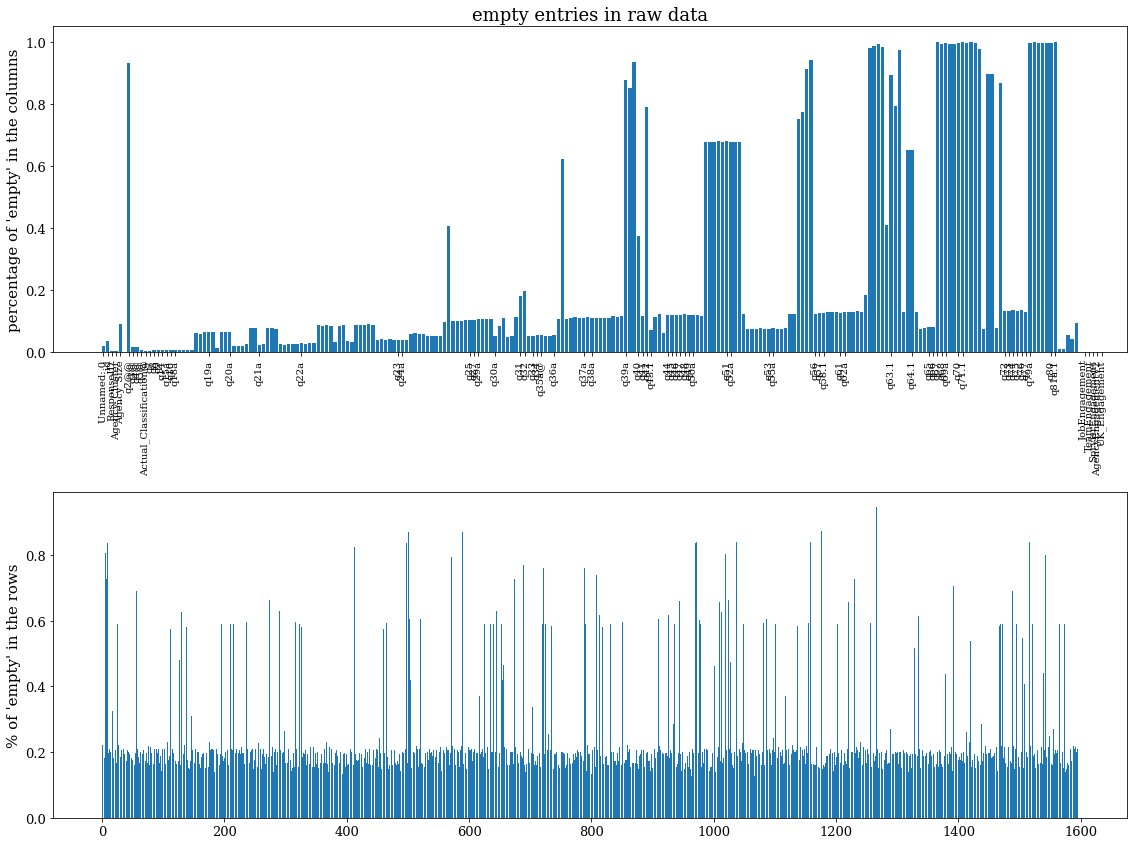

In [31]:
#git@github.com:Igodlab/Australian-Public-Service-APS.git

tick = [dat14.keys()[0], dat14.keys()[1], dat14.keys()[2], dat14.keys()[3], dat14.keys()[4]]
tick_ix = [0, 1, 2, 3, 4]

for j in range(5, dat14.shape[1]-1):
    if dat14.keys()[j][:3] != dat14.keys()[j+1][:3]:
        tick.append(dat14.keys()[j+1])
        tick_ix.append(j+1)
        
        
plt.figure(figsize=(16,12))
## print nas
naPercentage = emp2
naPercentage = naPercentage[naPercentage > 0]
plt.subplot(2,1,1)
plt.plot(figsize=(15,4))
plt.bar(naPercentage.index, naPercentage.values)
plt.xticks(tick_ix, tick, rotation='vertical', size=10)
plt.ylabel("percentage of 'empty' in the columns")
plt.title("empty entries in raw data")

## percentage of NA in the rows
naPercentage2 = emp2_row
naPercentage2 = naPercentage2[naPercentage2 > 0]
plt.subplot(2,1,2)
plt.plot(figsize=(15,4))
plt.bar(naPercentage2.index, naPercentage2.values)
plt.ylabel("% of 'empty' in the rows")

plt.tight_layout()
#savePNG("emptyEntries")

In [35]:
## male female percentages
dat14["q1"].value_counts()/dat14.shape[0]


## 

Male      0.830827
Female    0.149749
          0.019424
Name: q1, dtype: float64

# 2020 data

In [5]:
d20 = pd.read_csv(os.path.join("data", "d20Master.csv"), index_col=0)

In [6]:
d20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108085 entries, 0 to 108084
Columns: 213 entries, AS to q64.13
dtypes: float64(213)
memory usage: 176.5 MB


In [7]:
key = list(d20.keys())

In [8]:
for j in d20.keys()[:10]:
    print("\n\nPercentage of categories for "+j+": \n", d20[j].value_counts()/d20.shape[0])



Percentage of categories for AS: 
 3.0    0.865856
2.0    0.092501
1.0    0.041643
Name: AS, dtype: float64


Percentage of categories for q1: 
 2.0    0.596697
1.0    0.368923
4.0    0.031790
3.0    0.002591
Name: q1, dtype: float64


Percentage of categories for q2@: 
 2.0    0.440773
1.0    0.384373
3.0    0.174853
Name: q2@, dtype: float64


Percentage of categories for q5@: 
 1.0    0.672554
2.0    0.303067
3.0    0.024379
Name: q5@, dtype: float64


Percentage of categories for q17a: 
 2.0    0.591599
1.0    0.255012
3.0    0.083175
4.0    0.054846
5.0    0.015368
Name: q17a, dtype: float64


Percentage of categories for q17b: 
 2.0    0.558274
1.0    0.232123
3.0    0.120498
4.0    0.067345
5.0    0.021761
Name: q17b, dtype: float64


Percentage of categories for q17c: 
 2.0    0.487487
3.0    0.180016
1.0    0.175473
4.0    0.112023
5.0    0.045002
Name: q17c, dtype: float64


Percentage of categories for q17d: 
 2.0    0.498469
1.0    0.166110
3.0    0.157820
4.0    0.130129

## 2014  data

In [87]:
d14 = pd.read_csv(os.path.join("data", "d14Master.csv"), index_col=0)
d14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99392 entries, 0 to 99391
Columns: 208 entries, AS to q81e.1
dtypes: float64(158), int64(46), object(4)
memory usage: 158.5+ MB


In [88]:
for j in d14.keys()[:10]:
    print("\n\nPercentage of categories for "+j+": \n", d14[j].value_counts()/d14.shape[0])



Percentage of categories for AS: 
 3    0.874155
2    0.089383
1    0.036462
Name: AS, dtype: float64


Percentage of categories for q1: 
 2.0    0.565941
1.0    0.412981
3.0    0.009800
Name: q1, dtype: float64


Percentage of categories for q2@: 
 2.0    0.431866
1.0    0.375483
3.0    0.145807
Name: q2@, dtype: float64


Percentage of categories for q6@: 
 1.0    0.680437
2.0    0.297277
3.0    0.021149
Name: q6@, dtype: float64


Percentage of categories for q18a: 
 2.0    0.560437
1.0    0.202723
3.0    0.138200
4.0    0.068255
5.0    0.020696
Name: q18a, dtype: float64


Percentage of categories for q18b: 
 2.0    0.458518
1.0    0.318335
3.0    0.119195
4.0    0.062389
5.0    0.031300
Name: q18b, dtype: float64


Percentage of categories for q18c: 
 2.0    0.525908
1.0    0.180528
3.0    0.146471
4.0    0.100642
5.0    0.035727
Name: q18c, dtype: float64


Percentage of categories for q18d: 
 2.0    0.488460
3.0    0.184653
1.0    0.163625
4.0    0.110703
5.0    0.040657
Name:

In [89]:
for j in d14.keys():
    print("\n\n\nPercentage of categories for "+j+": \n", d14[j].value_counts()/d14.shape[0])




Percentage of categories for AS: 
 3    0.874155
2    0.089383
1    0.036462
Name: AS, dtype: float64



Percentage of categories for q1: 
 2.0    0.565941
1.0    0.412981
3.0    0.009800
Name: q1, dtype: float64



Percentage of categories for q2@: 
 2.0    0.431866
1.0    0.375483
3.0    0.145807
Name: q2@, dtype: float64



Percentage of categories for q6@: 
 1.0    0.680437
2.0    0.297277
3.0    0.021149
Name: q6@, dtype: float64



Percentage of categories for q18a: 
 2.0    0.560437
1.0    0.202723
3.0    0.138200
4.0    0.068255
5.0    0.020696
Name: q18a, dtype: float64



Percentage of categories for q18b: 
 2.0    0.458518
1.0    0.318335
3.0    0.119195
4.0    0.062389
5.0    0.031300
Name: q18b, dtype: float64



Percentage of categories for q18c: 
 2.0    0.525908
1.0    0.180528
3.0    0.146471
4.0    0.100642
5.0    0.035727
Name: q18c, dtype: float64



Percentage of categories for q18d: 
 2.0    0.488460
3.0    0.184653
1.0    0.163625
4.0    0.110703
5.0    0.0406




Percentage of categories for q38c: 
 3.0    0.394066
2.0    0.234174
4.0    0.183586
1.0    0.052741
5.0    0.025072
Name: q38c, dtype: float64



Percentage of categories for q38d: 
 4.0    0.353489
3.0    0.323336
2.0    0.129507
5.0    0.052620
1.0    0.029650
Name: q38d, dtype: float64



Percentage of categories for q38e: 
 4.0    0.370050
5.0    0.256580
3.0    0.219434
2.0    0.034067
1.0    0.011399
Name: q38e, dtype: float64



Percentage of categories for q38f: 
 3.0    0.312420
4.0    0.271953
2.0    0.208800
1.0    0.056333
5.0    0.041673
Name: q38f, dtype: float64



Percentage of categories for q38g: 
 3.0    0.322722
4.0    0.206576
2.0    0.194643
5.0    0.104274
1.0    0.064462
Name: q38g, dtype: float64



Percentage of categories for q38h: 
 3.0    0.392969
2.0    0.292005
4.0    0.125322
1.0    0.066826
5.0    0.014639
Name: q38h, dtype: float64



Percentage of categories for q39a: 
 3.0    0.322471
2.0    0.235492
4.0    0.198527
1.0    0.068869
5.0    0.06483




Percentage of categories for q80: 
 Not applicable (i.e. you did not experience pregnancy or did not take parental leave in the previous twelve months)    0.420215
2                                                                                                                      0.412629
1                                                                                                                      0.017979
3                                                                                                                      0.016842
Name: q80, dtype: float64



Percentage of categories for q81a.1: 
 0    0.995392
1    0.004608
Name: q81a.1, dtype: float64



Percentage of categories for q81b.1: 
 0    0.998672
1    0.001328
Name: q81b.1, dtype: float64



Percentage of categories for q81c.1: 
 0    0.993138
1    0.006862
Name: q81c.1, dtype: float64



Percentage of categories for q81d.1: 
 0    0.990301
1    0.009699
Name: q81d.1, dtype: float64



Percentage of categories

# 2. Exploratory Factor Analysis

In [12]:
def split_sets(x, trainP=0.2, rs=42, stratified=False):
    testP = 1-trainP
    train_set, test_set = train_test_split(x, test_size=trainP, random_state=rs)
    return train_set, test_set

In [24]:
## alphabety
alphabet = list(map(chr, range(97, 123)))

In [39]:
list(map(chr, range(97,104)))

['a', 'b', 'c', 'd', 'e', 'f', 'g']

In [14]:
def rm_cols(x, drp):
    drop_cols = []
    drp.append("nada")
    tick = [x.keys()[0], x.keys()[1], x.keys()[2], x.keys()[3]]
    tick_ix = [0, 1, 2, 3]

    for j in range(4, x.shape[1]):
        if x.keys()[j-1][:3] != x.keys()[j][:3]:
            tick.append(x.keys()[j])
            tick_ix.append(j)

    if "q64.1" in drp:
        drop_cols += ["q64."+str(i) for i in range(1,14)]
        rm_ix = drp.index("q64.1")
        drp.pop(rm_ix)
    
    ix = dict(zip(tick, tick_ix))
    for k in range(len(drp)-1):
        i0 = ix[drp[k]]
        i1 = tick_ix[tick_ix.index(i0)+1]
        drop_cols += list(x[list(x.keys()[i0:i1].values)].keys())
   
    return drop_cols

In [15]:
## sub 2 : is the best cjoice for clustering Leadership styles in 2020
sub2 = rm_cols(d20, ["q19a", "q21a"]) + ["q48e", "q47c"]

## compute new sets
X1 = d20[sub]
X2 = d20[sub2] 

In [16]:
sub2


['q19a',
 'q19b',
 'q19c',
 'q19d',
 'q19e',
 'q19f',
 'q19g',
 'q19h',
 'q21a',
 'q21b',
 'q21c',
 'q21d',
 'q21e',
 'q21f',
 'q48e',
 'q47c']

## 2.3 EFA

In [17]:
class ExpFacAn:

    def __init__(self, X, nFactors=5, rot=None):
        fa = FactorAnalyzer(n_factors=nFactors, rotation=rot)
        fa.fit(X)
        eigVal, Val = fa.get_eigenvalues()
        
        self.Fit = fa.fit(X)
        self.Eig = eigVal
        self.Val = Val
        
        '''
        Barlett specificity
        '''
        chi_square_value,p_value=calculate_bartlett_sphericity(X1)
        self.Barlett = (chi_square_value, p_value)

        '''
        Kaiser-Meyer_Olkin
        '''
        kmo_all, kmo_model=calculate_kmo(X1)
        self.KMO = kmo_model

        EFAloadings = pd.DataFrame(fa.loadings_, columns=["Factor "+str(i+1) for i in range(nFactors)])
        EFAloadings["q"] = list(X.keys())
        EFAloadings = EFAloadings.set_index("q")
        
        self.loadings = EFAloadings

/home/igodlab/anaconda3/envs/pytorch-env/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


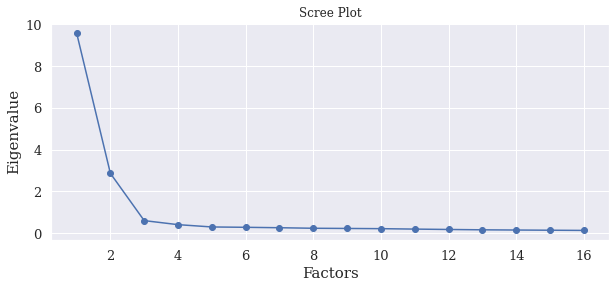

In [18]:
## EFA for X2
efaX2 = ExpFacAn(X2, rot="varimax")

## plot
plt.scatter(range(1,X2.shape[1]+1),efaX2.Eig)
plt.plot(range(1,X2.shape[1]+1),efaX2.Eig)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

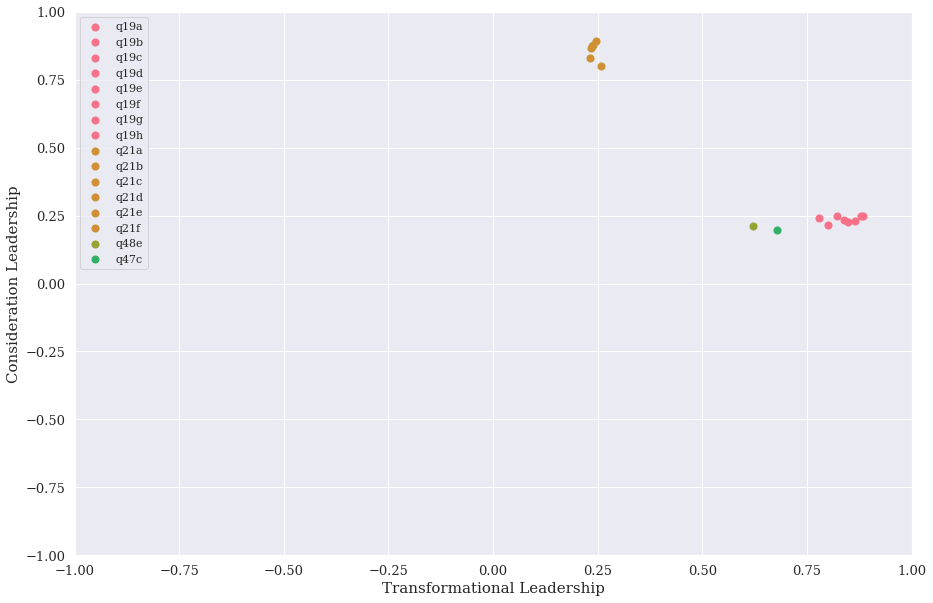

In [19]:
fig2 = plt.figure(figsize=(15,10))
axes = fig2.add_subplot(111)#, projection='3d')

ax_x = "Factor 1"
ax_y = "Factor 2"

color_i = 0


axes.scatter(efaX2.loadings[ax_x][0],efaX2.loadings[ax_y][0], marker='o', color=cpalette[color_i], s=50, label=efaX2.loadings.index[0])
for i in range(1, efaX2.loadings.shape[0]):
    x = efaX2.loadings[ax_x][i]
    y = efaX2.loadings[ax_y][i]
    #z = efaX1.loadings["Factor 3"][i]
    color_i = (color_i % (len(cpalette)-1))
    if efaX2.loadings.index[i-1][2] != efaX2.loadings.index[i][2]:
        color_i += 1
    #color_i += 1
    axes.scatter(x,y, marker='o', color=cpalette[color_i], s=50, label=efaX2.loadings.index[i])
    
axes.set_xlabel("Transformational Leadership")
axes.set_ylabel("Consideration Leadership")
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
#axes.set_zlabel("Factor 3")
axes.legend()

#savePNG("FactorAnalysisLFI-2020.png")

In [94]:
d14Cat = pd.read_csv(os.path.join("data", "2014-aps-employee-census-5-point-dataset.csv"))
d14Cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99392 entries, 0 to 99391
Columns: 225 entries, AS to q81g.1
dtypes: object(225)
memory usage: 170.6+ MB


In [99]:
drop_cols_init = ["q45", "q52a", "q66", "q67", "q72", "q74", "q75", "q77", "q80"]
bin_cols = ["q26.1", "q43.1", "q58.1", "q63.1", "q64.1", "q71.1", "q81a.1"]
def rm_cols(x, drp):
    drop_cols = []
    ix = dict(zip(tick, tick_ix))
    for k in range(len(drp)-1):
        i0 = ix[drp[k]]
        i1 = tick_ix[tick_ix.index(i0)+1]
        drop_cols += list(x[list(x.keys()[i0:i1].values)].keys())
    
    if ("q80" in drp) & ("q80" not in drop_cols):
        drop_cols += ["q80"]
    if ("q81a.1" in drp) & ("q81a.1" not in drop_cols):
        drop_cols += ["q81"+str(c)+".1" for c in list(map(chr, range(97, 104)))]
    return drop_cols


In [100]:
drop_cols = rm_cols(d14Cat, drop_cols_init)
drop_cols

['q45',
 'q52a',
 'q52b',
 'q52c',
 'q52d',
 'q52e',
 'q52f',
 'q52g',
 'q52h',
 'q52i',
 'q66',
 'q67',
 'q72',
 'q74',
 'q75',
 'q77',
 'q80']